$V(x)=\sum_{t=0}^\infty \gamma^t R(x(t))$ \
where  $R(x)=Constant-\|x-x_{goal}\|>0$ \
and $\gamma=0.5$

# Create Environment

In [1]:
import numpy as np
import matplotlib.pylab as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from tqdm import tqdm

global N

N=50

global M
M=10

global T
global target
T=15
target=np.array([3,2])
global w
w=np.pi*2/23.7

global delta_t
delta_t=T/N

global beta
beta=[1]

global num_system
num_system=1

In [2]:
def Z(vecs, u, v):
    output=[]
    for i in range(num_system):
        vec=vecs[i]
        x=vec[0]
        y=vec[1]
        theta=vec[2]
        output.append([beta[i]*np.cos(theta)*u,beta[i]*np.sin(theta)*u,beta[i]*v])
    return np.array(output)

#check the correctness of Z
'''
x = np.linspace(0, 6.5, 1001)
plt.plot(x, Z(x))
plt.xlabel('Angle [rad]')
plt.ylabel('Z(theta)')
plt.grid()
plt.show()
'''

"\nx = np.linspace(0, 6.5, 1001)\nplt.plot(x, Z(x))\nplt.xlabel('Angle [rad]')\nplt.ylabel('Z(theta)')\nplt.grid()\nplt.show()\n"

In [3]:
def next_step(vecs,action):  
    u=action[0]
    v=action[1]
   
    for j in range(M):
        vecs_new=[]
        diff=Z(vecs,u,v)
        for i in range(num_system):
            w=vecs[i]+delta_t/M*diff[i]
            '''
            if w[2]>np.pi:
                w[2]-=2*np.pi
            if w[2]<-np.pi:
                w[2]+=2*np.pi
            '''
            vecs_new.append(w)
        vecs=np.array(vecs_new)
    return vecs

def observe(vecs):
    mu_x=0
    mu_y=0
    mu_theta=0
    var_x=0
    var_y=0
    for i in range(num_system):
        mu_x+=vecs[i][0]
        mu_y+=vecs[i][1]
        mu_theta+=vecs[i][2]
        var_x+=vecs[i][0]**2
        var_y+=vecs[i][1]**2
    var_x-=mu_x**2/num_system
    var_y-=mu_y**2/num_system
    
    w=np.array([mu_x,mu_y,mu_theta,var_x,var_y])/num_system
    
    if w[2]>np.pi:
        w[2]-=2*np.pi
    if w[2]<-np.pi:
        w[2]+=2*np.pi
   
    return w

def reward(obs):
    return max(100-(obs[0]-target[0])**2-(obs[1]-target[1])**2,0)

def reward_raw(position):
    r=0
    for i in range(num_system):
        r+=np.linalg.norm(position[i,[0,1]]-target)
    return r



# Learning Settings

In [4]:
global lr
lr=0.7
global eps
eps=0.1
global max_u
max_u=2
global precision
precision=0.0002
global action_set
action_set=np.array([[1,np.pi/4],[-1,np.pi/4],[1,0],[-1,0],[1,-np.pi/4],[-1,-np.pi/4]])

def exploration():
    a=np.random.uniform()
    if a<eps:
        return True
    else:
        return False

def find_max(cand):
    return np.argmax(cand)
    
def decide_u(theta,cand,std,init=False):
    explo=exploration()
    #print("cand",cand.shape)
    #print("std",std.shape)
    if init:
        return(np.random.randint(6)), True
    elif explo:
        return(find_max(std)), True
    else:
        return(find_max(cand)), False
    
def generate_history_pred(gp_list,history):
    cand=[]
    for j in range(len(gp_list)):
        pred=gp_list[j].predict(history.reshape(-1,5), return_std=False).reshape(-1,1)
        if j==0:
            cand=pred
        else:
            cand=np.concatenate((cand,pred),axis=1)
    output=[]
    for j in range(history.shape[0]):
        output.append([np.max(cand[j])])
    return np.array(output)
        
    
def decide_u_exploitation(theta,cand,init=False):
    return find_max(cand)


def trainingset_refine(history_su,history_su_next, history_r, num=1000):
    if history_su.shape[0]<num:
        return history_su, history_su_next, history_r
    else:
        history_su=history_su[-num:-1]
        history_su_next=history_su_next[-num:-1]
        history_r=history_r[-num:-1]
        return history_su,history_su_next,history_r


history_su=[0 for i in range(6)]
history_r=[0 for i in range(6)]
history_su_next=[0 for i in range(6)]
flags=[True for i in range(6)]

# Simulation


In [5]:
num_iter=100

position_result=[]
observation_result=[]
gpr_list=[]

best_r=-10000
best_obs=[]
best_pos=[[] for i in range(5)]
best_u=[]

for iterr in tqdm(range(num_iter)):
    #initialize
    position=np.array([[-2,-2,0],[-2,-2,0],[-2,-2,0],[-2,-2,0],[-2,-2,0]])
    observation=observe(position)
    u_t=[]
    observation_t=[observation]
    position_t=[[] for i in range(5)]
    
    
    for time in range(N+1):
        if iterr==0:
            candidates_u=[]
            std=[]
            u_k, _ = decide_u(observation,np.array(candidates_u),np.array(std),init=True)
            position_new = next_step(position,action_set[u_k])
            observation_new = observe(position_new)
            r = reward(observation_new)
            
            if flags[u_k]:
                history_su[u_k] = observation.reshape(-1,5)
                history_su_next[u_k] = observation_new.reshape(-1,5)  
                history_r[u_k] = np.array([r])
                flags[u_k]=False
            else:
                history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
                history_su_next[u_k] = np.concatenate((history_su_next[u_k], observation_new.reshape(-1,5)))
                history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            
            observation=observation_new
            position=position_new
            u_t.append(u_k)
            observation_t.append(observation)
            for i in range(num_system):
                position_t[i].append(position[i])
            
            
        else:            
            candidates_u=[]
            std=[]
            for i in range(6):
                cand, var = gpr_list[i].predict(observation.reshape(-1,5), return_std=True)
                candidates_u.append(cand[0])
                std.append(var[0])
            #print(candidates_u)
            #print(var)
            u_k, explo = decide_u(observation,np.array(candidates_u),np.array(std))
            position_new = next_step(position,action_set[u_k])
            observation_new = observe(position_new)
            r = reward(observation_new)
            #if r>0.1:
            if explo:
                history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
                history_su_next[u_k] = np.concatenate((history_su_next[u_k], observation_new.reshape(-1,5)))
                history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            else:
                a=np.random.uniform()
                if a<0.25:
                    history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
                    history_su_next[u_k] = np.concatenate((history_su_next[u_k], observation_new.reshape(-1,5)))
                    history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
            
            observation=observation_new
            position=position_new
            u_t.append(u_k)
            observation_t.append(observation)
            for i in range(num_system):
                position_t[i].append(position[i])
            
            if time%((N+1)//3+1)==0:
                for i in range(6):
                    history_target=history_r[i].reshape(-1,1)+0.5*generate_history_pred(gpr_list,history_su_next[i])
                    gpr_list[i]=GaussianProcessRegressor(alpha=1e-6).fit(history_su[i], history_target)
                
                '''
                for i in range(6):
                    hist_su, hist_su_next, hist_r = trainingset_refine(history_su[i],history_su_next[i], history_r[i])
                    history_target=hist_r.reshape(-1,1)+0.01*generate_history_pred(gpr_list,hist_su_next)
                    gpr_list[i]=GaussianProcessRegressor(alpha=1e-4).fit(hist_su, history_target)
                '''
            '''
            if r>100-0.03:
                break
            '''
            
    if iterr==0:
        for i in range(6):
            gpr_list.append(GaussianProcessRegressor(alpha=1e-6).fit(history_su[i], history_r[i].reshape(-1,1)))
    else:       
        for i in range(6):
            history_target=history_r[i].reshape(-1,1)+0.5*generate_history_pred(gpr_list,history_su_next[i])
            gpr_list[i]=GaussianProcessRegressor(alpha=1e-6).fit(history_su[i], history_target)
            #print(history_su[i].shape[0])
        '''
        for i in range(6):
            hist_su, hist_su_next, hist_r = trainingset_refine(history_su[i],history_su_next[i], history_r[i])
            history_target=hist_r.reshape(-1,1)+0.01*generate_history_pred(gpr_list,hist_su_next)
            gpr_list[i]=GaussianProcessRegressor(alpha=1e-4).fit(hist_su, history_target)
            print(history_su[i].shape[0])
        '''
            
    print("observation =",observation)
    #print(observation_t)
    position_result.append(position)
    observation_result.append(observation)
    if r>best_r:
        best_r=r
        best_obs=observation_t
        best_pos=position_t
        best_u=u_t
    
    #print(history_su.shape)
    #print(u_t)

  2%|█▋                                                                                | 2/100 [00:00<00:08, 11.79it/s]

observation = [-1.11049588 -2.37224455 -0.23561945  0.          0.        ]
observation = [ 0.92418802 -4.19294129 -2.35619449  0.          0.        ]


  4%|███▎                                                                              | 4/100 [00:00<00:10,  9.04it/s]

observation = [ 3.29519784e-02 -1.44348982e+00  6.93889390e-18  0.00000000e+00
  0.00000000e+00]
observation = [-1.42889392e+00 -1.21622091e+00  4.85722573e-17  0.00000000e+00
  0.00000000e+00]


  6%|████▉                                                                             | 6/100 [00:00<00:10,  8.59it/s]

observation = [ 1.03271607 -4.12439942 -2.59181394  0.          0.        ]
observation = [ 0.65466881 -1.27477143 -0.70685835  0.          0.        ]


  8%|██████▌                                                                           | 8/100 [00:00<00:10,  8.47it/s]

observation = [ 5.09376777 -0.242162    0.23561945  0.          0.        ]
observation = [ 4.02899183 -0.46504321  0.23561945  0.          0.        ]


 10%|████████                                                                         | 10/100 [00:01<00:12,  7.49it/s]

observation = [ 8.82146281 -0.37808265  0.23561945  0.          0.        ]
observation = [ 3.88730390e+00 -3.52164092e-01  6.24500451e-17  0.00000000e+00
  0.00000000e+00]


 12%|█████████▋                                                                       | 12/100 [00:01<00:12,  7.09it/s]

observation = [7.23221497 1.99816485 1.17809725 0.         0.        ]
observation = [ 4.58396533 -0.85285912  2.98451302  0.          0.        ]


 14%|███████████▎                                                                     | 14/100 [00:01<00:12,  6.75it/s]

observation = [10.52728466  0.08624352  0.23561945  0.          0.        ]
observation = [ 5.03003524 -1.0412687  -1.64933614  0.          0.        ]


 16%|████████████▉                                                                    | 16/100 [00:02<00:13,  6.37it/s]

observation = [ 0.71241961 -3.42921756 -2.59181394  0.          0.        ]
observation = [ 3.41733335 -4.78705948 -0.9424778   0.          0.        ]


 18%|██████████████▌                                                                  | 18/100 [00:02<00:11,  6.83it/s]

observation = [ 4.01037432 -0.06674361  0.4712389   0.          0.        ]
observation = [ 2.71634256 -4.17162225 -0.9424778   0.          0.        ]


 20%|████████████████▏                                                                | 20/100 [00:02<00:11,  7.10it/s]

observation = [4.49195759 0.0157653  0.23561945 0.         0.        ]
observation = [ 1.71306412 -2.44377532  2.98451302  0.          0.        ]


 22%|█████████████████▊                                                               | 22/100 [00:02<00:10,  7.09it/s]

observation = [ 4.54733152 -1.16772586 -0.4712389   0.          0.        ]
observation = [ 3.30414313 -0.21598702 -0.4712389   0.          0.        ]


 24%|███████████████████▍                                                             | 24/100 [00:03<00:10,  7.09it/s]

observation = [3.26553521 0.01881532 0.23561945 0.         0.        ]
observation = [ 2.24334818 -1.27607346  2.98451302  0.          0.        ]


 26%|█████████████████████                                                            | 26/100 [00:03<00:10,  6.99it/s]

observation = [ 3.46172098 -1.14285673 -2.35619449  0.          0.        ]
observation = [ 3.33813196 -1.80868812  2.98451302  0.          0.        ]


 28%|██████████████████████▋                                                          | 28/100 [00:03<00:10,  6.57it/s]

observation = [6.0887444  6.44939673 0.70685835 0.         0.        ]
observation = [7.81804627 5.2711397  1.17809725 0.         0.        ]


 30%|████████████████████████▎                                                        | 30/100 [00:04<00:11,  6.18it/s]

observation = [2.55274919 6.09777313 0.70685835 0.         0.        ]
observation = [7.63249419 4.56046869 0.70685835 0.         0.        ]


 32%|█████████████████████████▉                                                       | 32/100 [00:04<00:11,  5.93it/s]

observation = [ 2.45277392  1.65783525 -1.41371669  0.          0.        ]
observation = [1.43951326 1.53333498 0.70685835 0.         0.        ]


 34%|███████████████████████████▌                                                     | 34/100 [00:04<00:11,  5.99it/s]

observation = [ 2.48540353 -0.70007457 -2.98451302  0.          0.        ]
observation = [8.13247051 5.32183288 0.9424778  0.         0.        ]


 36%|█████████████████████████████▏                                                   | 36/100 [00:05<00:10,  5.94it/s]

observation = [1.24961608 0.90973715 1.17809725 0.         0.        ]
observation = [6.04975583 6.37989118 1.88495559 0.         0.        ]


 38%|██████████████████████████████▊                                                  | 38/100 [00:05<00:10,  5.88it/s]

observation = [ 2.23747226 -0.77796417 -2.98451302  0.          0.        ]
observation = [ 1.91074451 -1.63971484  2.98451302  0.          0.        ]


 40%|████████████████████████████████▍                                                | 40/100 [00:05<00:10,  5.65it/s]

observation = [0.96593474 0.98532532 1.17809725 0.         0.        ]
observation = [0.81815176 1.10936891 0.9424778  0.         0.        ]


 42%|██████████████████████████████████                                               | 42/100 [00:06<00:10,  5.49it/s]

observation = [ 3.26466081 -1.75593556 -3.06305284  0.          0.        ]
observation = [2.24511414 6.53425289 0.23561945 0.         0.        ]


 44%|███████████████████████████████████▋                                             | 44/100 [00:06<00:10,  5.27it/s]

observation = [2.85449917 1.16286479 3.06305284 0.         0.        ]
observation = [ 2.03048422 -0.53145678 -0.4712389   0.          0.        ]


 46%|█████████████████████████████████████▎                                           | 46/100 [00:07<00:10,  5.10it/s]

observation = [2.16740884 0.0971076  3.06305284 0.         0.        ]
observation = [2.63520198 3.8295417  1.41371669 0.         0.        ]


 47%|██████████████████████████████████████                                           | 47/100 [00:07<00:10,  5.06it/s]

observation = [3.4069848  1.94832103 0.9424778  0.         0.        ]


 48%|██████████████████████████████████████▉                                          | 48/100 [00:07<00:10,  4.89it/s]

observation = [1.77626902 1.87388385 1.41371669 0.         0.        ]


 49%|███████████████████████████████████████▋                                         | 49/100 [00:07<00:10,  4.80it/s]

observation = [2.9189578  0.61888344 0.70685835 0.         0.        ]


 50%|████████████████████████████████████████▌                                        | 50/100 [00:07<00:10,  4.63it/s]

observation = [-2.64723433  8.06713939  2.12057504  0.          0.        ]


 51%|█████████████████████████████████████████▎                                       | 51/100 [00:08<00:11,  4.41it/s]

observation = [ 4.40819897e+00 -2.22561076e-01  6.24500451e-17  0.00000000e+00
  0.00000000e+00]


 52%|██████████████████████████████████████████                                       | 52/100 [00:08<00:11,  4.07it/s]

observation = [2.33278623 2.29794481 1.17809725 0.         0.        ]


 53%|██████████████████████████████████████████▉                                      | 53/100 [00:08<00:11,  4.06it/s]

observation = [2.38974441 2.11921669 0.9424778  0.         0.        ]


 54%|███████████████████████████████████████████▋                                     | 54/100 [00:09<00:11,  4.02it/s]

observation = [2.35670148 2.24219039 0.9424778  0.         0.        ]


 55%|████████████████████████████████████████████▌                                    | 55/100 [00:09<00:11,  3.89it/s]

observation = [2.16681477 0.56656242 1.64933614 0.         0.        ]


 56%|█████████████████████████████████████████████▎                                   | 56/100 [00:09<00:11,  3.77it/s]

observation = [5.52283243 7.01302438 1.17809725 0.         0.        ]


 57%|██████████████████████████████████████████████▏                                  | 57/100 [00:09<00:11,  3.73it/s]

observation = [9.08237642e+00 2.67784690e+00 4.85722573e-17 0.00000000e+00
 0.00000000e+00]


 58%|██████████████████████████████████████████████▉                                  | 58/100 [00:10<00:12,  3.48it/s]

observation = [5.54113216 6.29830645 1.41371669 0.         0.        ]


 59%|███████████████████████████████████████████████▊                                 | 59/100 [00:10<00:12,  3.35it/s]

observation = [ 2.15075772 -1.69921667  2.98451302  0.          0.        ]


 60%|████████████████████████████████████████████████▌                                | 60/100 [00:10<00:11,  3.41it/s]

observation = [ 3.25080238 -1.30175441 -3.06305284  0.          0.        ]


 61%|█████████████████████████████████████████████████▍                               | 61/100 [00:11<00:11,  3.45it/s]

observation = [4.44733729e+00 5.77875266e+00 4.85722573e-17 0.00000000e+00
 0.00000000e+00]


 62%|██████████████████████████████████████████████████▏                              | 62/100 [00:11<00:10,  3.45it/s]

observation = [4.47764595 1.32377105 2.59181394 0.         0.        ]


 63%|███████████████████████████████████████████████████                              | 63/100 [00:11<00:10,  3.37it/s]

observation = [2.81022308 2.38173962 0.70685835 0.         0.        ]


 64%|███████████████████████████████████████████████████▊                             | 64/100 [00:12<00:10,  3.32it/s]

observation = [2.89746315 2.57215655 1.17809725 0.         0.        ]


 65%|████████████████████████████████████████████████████▋                            | 65/100 [00:12<00:10,  3.23it/s]

observation = [9.23477034 4.82385569 0.4712389  0.         0.        ]


 66%|█████████████████████████████████████████████████████▍                           | 66/100 [00:12<00:10,  3.15it/s]

observation = [3.1160225  1.5383192  1.88495559 0.         0.        ]


 67%|██████████████████████████████████████████████████████▎                          | 67/100 [00:13<00:10,  3.06it/s]

observation = [ 3.61277211 -0.01387841 -0.70685835  0.          0.        ]


 68%|███████████████████████████████████████████████████████                          | 68/100 [00:13<00:10,  2.93it/s]

observation = [3.20182347 1.55331339 1.17809725 0.         0.        ]


 69%|███████████████████████████████████████████████████████▉                         | 69/100 [00:13<00:11,  2.68it/s]

observation = [3.34763662 2.12771666 1.64933614 0.         0.        ]


 70%|████████████████████████████████████████████████████████▋                        | 70/100 [00:14<00:11,  2.66it/s]

observation = [ 2.52543696  0.65028344 -2.98451302  0.          0.        ]


 71%|█████████████████████████████████████████████████████████▌                       | 71/100 [00:14<00:10,  2.68it/s]

observation = [4.2114089  1.60548452 0.23561945 0.         0.        ]


 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [00:15<00:10,  2.59it/s]

observation = [2.80472114e+00 2.63551716e+00 4.85722573e-17 0.00000000e+00
 0.00000000e+00]


 73%|███████████████████████████████████████████████████████████▏                     | 73/100 [00:15<00:11,  2.45it/s]

observation = [3.43171179 2.09274273 1.41371669 0.         0.        ]


 74%|███████████████████████████████████████████████████████████▉                     | 74/100 [00:15<00:10,  2.46it/s]

observation = [3.57451464 1.56950674 1.88495559 0.         0.        ]


 75%|████████████████████████████████████████████████████████████▊                    | 75/100 [00:16<00:10,  2.34it/s]

observation = [4.75981464 3.48867729 1.64933614 0.         0.        ]


 76%|█████████████████████████████████████████████████████████████▌                   | 76/100 [00:16<00:10,  2.38it/s]

observation = [4.26651438 1.04046901 0.23561945 0.         0.        ]


 77%|██████████████████████████████████████████████████████████████▎                  | 77/100 [00:17<00:09,  2.32it/s]

observation = [3.25882439 1.76261714 1.88495559 0.         0.        ]


 78%|███████████████████████████████████████████████████████████████▏                 | 78/100 [00:17<00:09,  2.27it/s]

observation = [4.68231687 1.75981883 2.59181394 0.         0.        ]


 79%|███████████████████████████████████████████████████████████████▉                 | 79/100 [00:18<00:09,  2.23it/s]

observation = [2.47256558 2.31435014 1.88495559 0.         0.        ]


 80%|████████████████████████████████████████████████████████████████▊                | 80/100 [00:18<00:09,  2.17it/s]

observation = [3.11047907 2.45903593 0.70685835 0.         0.        ]


 81%|█████████████████████████████████████████████████████████████████▌               | 81/100 [00:19<00:08,  2.13it/s]

observation = [3.35182821 2.23059946 0.70685835 0.         0.        ]


 82%|██████████████████████████████████████████████████████████████████▍              | 82/100 [00:19<00:08,  2.09it/s]

observation = [3.06642247 2.41009849 1.64933614 0.         0.        ]


 83%|███████████████████████████████████████████████████████████████████▏             | 83/100 [00:20<00:08,  2.01it/s]

observation = [ 4.07495796  0.56583008 -0.70685835  0.          0.        ]


 84%|████████████████████████████████████████████████████████████████████             | 84/100 [00:20<00:08,  1.99it/s]

observation = [ 3.75820633  1.37449381 -2.98451302  0.          0.        ]


 85%|████████████████████████████████████████████████████████████████████▊            | 85/100 [00:21<00:07,  1.96it/s]

observation = [ 3.306018    1.46032041 -2.98451302  0.          0.        ]


 86%|█████████████████████████████████████████████████████████████████████▋           | 86/100 [00:21<00:07,  1.95it/s]

observation = [3.58724409 1.59509678 1.64933614 0.         0.        ]


 87%|██████████████████████████████████████████████████████████████████████▍          | 87/100 [00:22<00:06,  1.92it/s]

observation = [7.56989292 5.58510151 1.17809725 0.         0.        ]


 88%|███████████████████████████████████████████████████████████████████████▎         | 88/100 [00:22<00:06,  1.93it/s]

observation = [ 3.67502009 -0.08197531 -1.17809725  0.          0.        ]


 89%|████████████████████████████████████████████████████████████████████████         | 89/100 [00:23<00:05,  1.95it/s]

observation = [ 3.40133297  0.7143791  -1.17809725  0.          0.        ]


 90%|████████████████████████████████████████████████████████████████████████▉        | 90/100 [00:23<00:05,  1.87it/s]

observation = [2.90694161e+00 1.76196881e+00 4.85722573e-17 0.00000000e+00
 0.00000000e+00]


 91%|█████████████████████████████████████████████████████████████████████████▋       | 91/100 [00:24<00:04,  1.84it/s]

observation = [2.73110277 1.94562506 0.9424778  0.         0.        ]


 92%|██████████████████████████████████████████████████████████████████████████▌      | 92/100 [00:24<00:04,  1.81it/s]

observation = [ 2.60206184 -0.39489547 -3.06305284  0.          0.        ]


 93%|███████████████████████████████████████████████████████████████████████████▎     | 93/100 [00:25<00:03,  1.76it/s]

observation = [ 3.20363121 -0.44370845 -2.82743339  0.          0.        ]


 94%|████████████████████████████████████████████████████████████████████████████▏    | 94/100 [00:26<00:03,  1.70it/s]

observation = [2.85333284 1.89232773 0.4712389  0.         0.        ]


 95%|████████████████████████████████████████████████████████████████████████████▉    | 95/100 [00:26<00:03,  1.62it/s]

observation = [ 2.79944736  1.91947125 -0.23561945  0.          0.        ]


 96%|█████████████████████████████████████████████████████████████████████████████▊   | 96/100 [00:27<00:02,  1.57it/s]

observation = [2.84648761 1.87667021 0.9424778  0.         0.        ]


 97%|██████████████████████████████████████████████████████████████████████████████▌  | 97/100 [00:28<00:01,  1.57it/s]

observation = [3.32911356 2.00083752 0.70685835 0.         0.        ]


 98%|███████████████████████████████████████████████████████████████████████████████▍ | 98/100 [00:28<00:01,  1.57it/s]

observation = [3.57245169 2.31208413 1.88495559 0.         0.        ]


 99%|████████████████████████████████████████████████████████████████████████████████▏| 99/100 [00:29<00:00,  1.58it/s]

observation = [2.98720066 2.39401541 1.64933614 0.         0.        ]


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:30<00:00,  3.32it/s]

observation = [2.86162744 1.84683563 0.4712389  0.         0.        ]


# Results

## Last Control

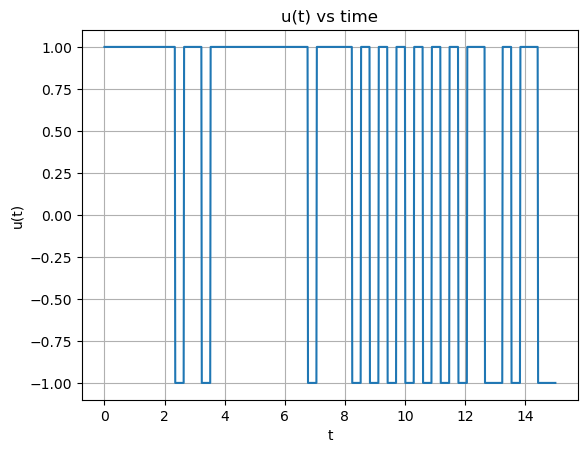

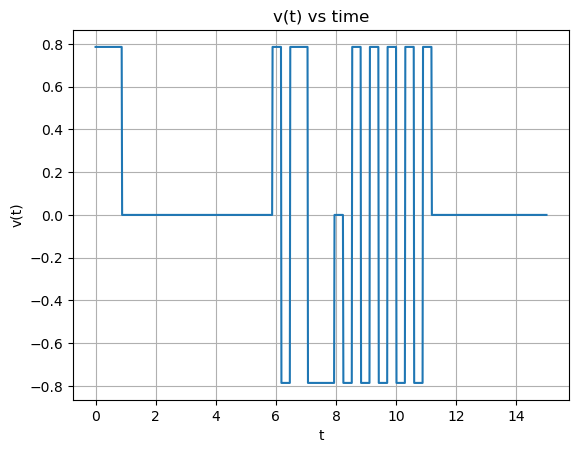

In [6]:
us=[2*(0.5-i%2) for i in u_t]
vs=[(1-i//2)*np.pi/4 for i in u_t]

u=[]
v=[]
for i in range(len(us)):
    for j in range(20):
        u.append(us[i])
        v.append(vs[i])
        
x = np.linspace(0, T, (N+1)*20)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

## Last Trajectory


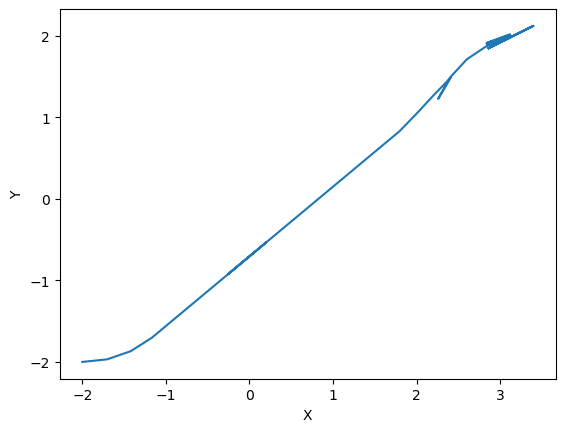

In [7]:
obs=np.array(observation_t)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

### End point and Goal

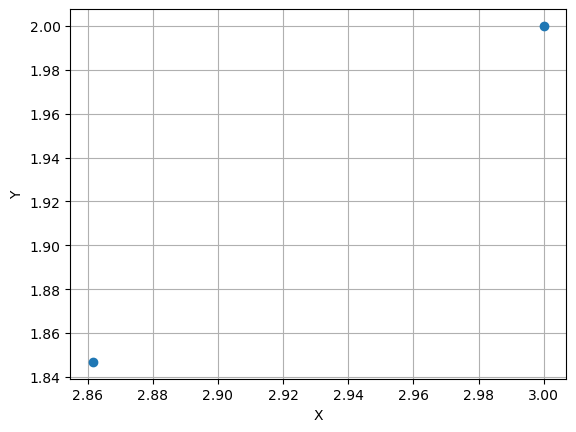

0.206412912291682


In [8]:
pos=[]
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[:,[0,1]]
    #plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])

plt.plot(np.array([3,obs[-1,0]]),np.array([2,obs[-1,1]]), 'o')
#plt.plot(obs[-1,0],obs[-1,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()

print(reward_raw(np.array(pos)))

## Best Control

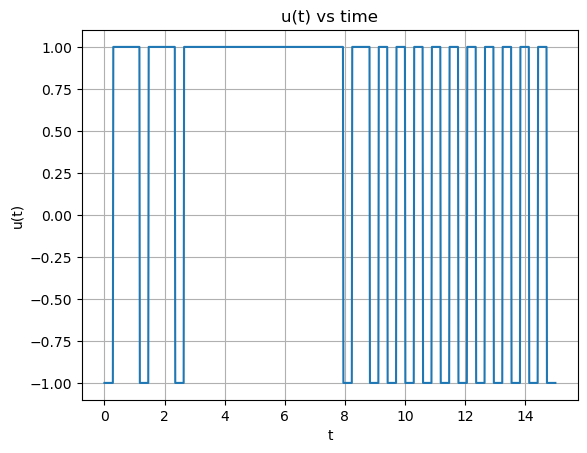

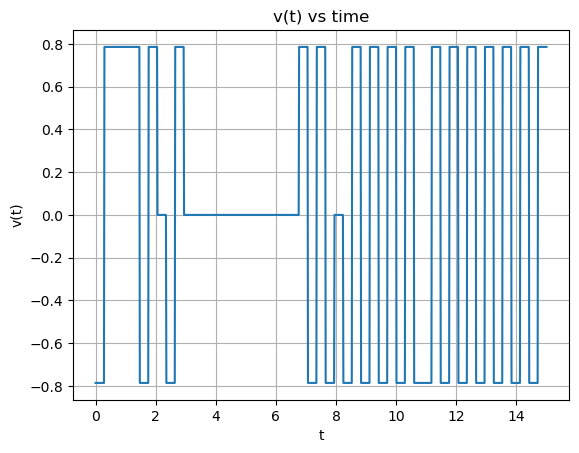

In [9]:
us=[2*(0.5-i%2) for i in best_u]
vs=[(1-i//2)*np.pi/4 for i in best_u]

u=[]
v=[]
for i in range(len(us)):
    for j in range(20):
        u.append(us[i])
        v.append(vs[i])

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

## Best Trajectory

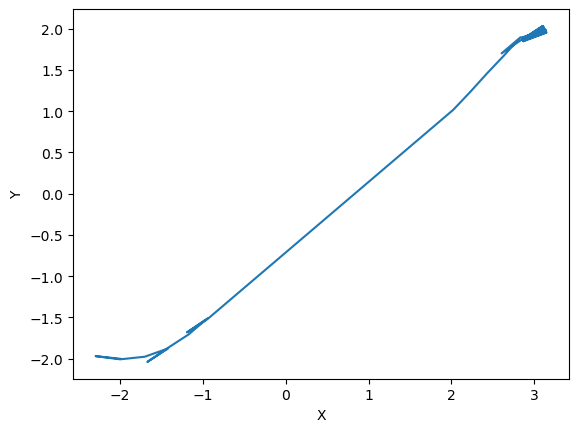

In [10]:
obs=np.array(best_obs)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

### End point and Goal

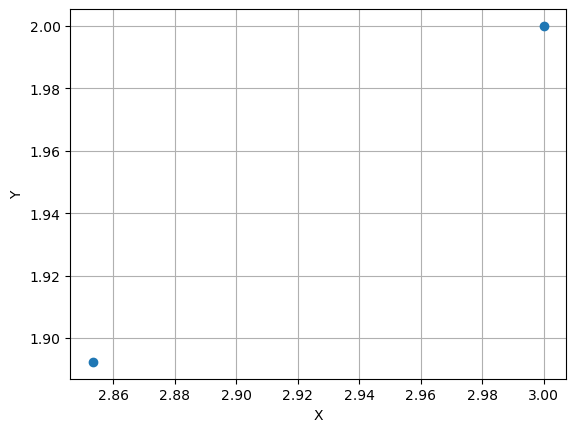

0.1819466229462131


In [11]:
pos=[]
for i in range(num_system):
    obs=np.array(best_pos[i])
    obs=obs[:,[0,1]]
    #plt.plot(obs[:,0],obs[:,1])
    pos.append(obs[-1])
    
plt.plot(np.array([3,obs[-1,0]]),np.array([2,obs[-1,1]]), 'o')
#plt.plot(obs[-1,0],obs[-1,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()

print(reward_raw(np.array(pos)))

## Pure Exploitation Control and Trajectory

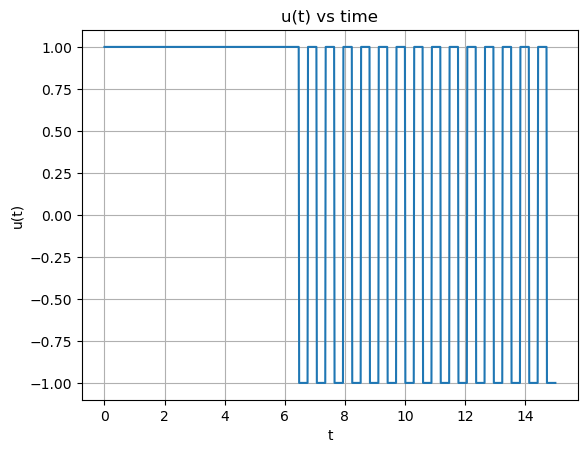

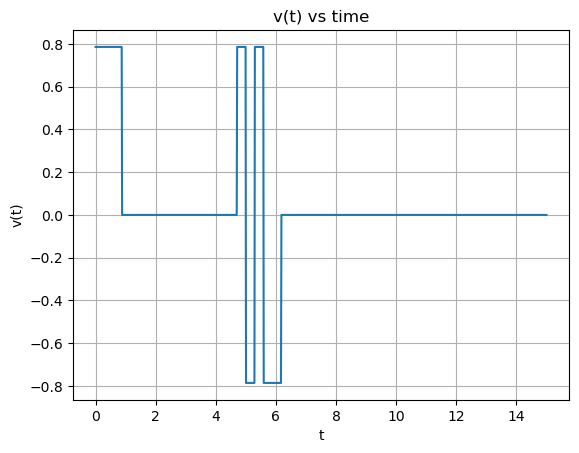

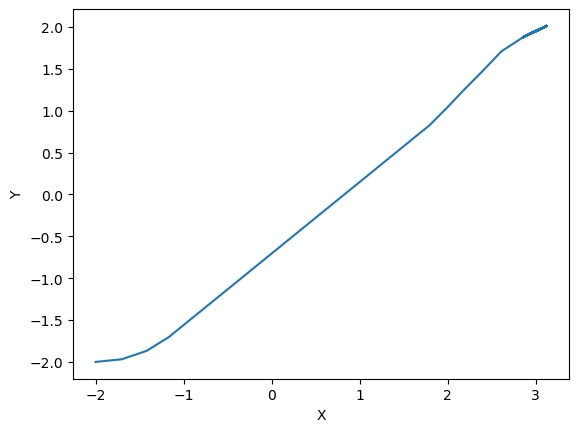

In [12]:
position=np.array([[-2,-2,0],[-2,-2,0],[-2,-2,0],[-2,-2,0],[-2,-2,0]])
observation=observe(position)
u_t=[]
observation_t=[observation]
position_t=[[] for i in range(5)]

for time in range(N+1):           
    candidates_u=[]
    for i in range(6):
        cand, _ = gpr_list[i].predict(observation.reshape(-1,5), return_std=True)
        candidates_u.append(cand[0])
    #print(candidates_u)
    u_k = decide_u_exploitation(observation,np.array(candidates_u))
    position_new = next_step(position,action_set[u_k])
    observation_new = observe(position_new)
    r = reward(observation_new)
    '''
    if explo:
        history_su[u_k] = np.concatenate((history_su[u_k], observation.reshape(-1,5)))
        history_r[u_k] = np.concatenate((history_r[u_k],np.array([r])))
    '''
    observation=observation_new
    position=position_new
    u_t.append(u_k)
    observation_t.append(observation)
    for i in range(num_system):
        position_t[i].append(position[i])
    '''
    if time%((N+1)//3+1)==0:
        for i in range(6):
            gpr_list[i]=GaussianProcessRegressor(alpha=1e-8).fit(history_su[i], history_r[i].reshape(-1,1))
    
    if r>100-0.03:
        break
    '''
us=[2*(0.5-i%2) for i in u_t]
vs=[(1-i//2)*np.pi/4 for i in u_t]

u=[]
v=[]
for i in range(len(us)):
    for j in range(20):
        u.append(us[i])
        v.append(vs[i])
    

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, u)
plt.xlabel('t')
plt.ylabel('u(t)')
plt.title("u(t) vs time")
plt.grid()
plt.show()

x = np.linspace(0, T, (N+1)*20)
plt.plot(x, v)
plt.xlabel('t')
plt.ylabel('v(t)')
plt.title("v(t) vs time")
plt.grid()
plt.show()

obs=np.array(observation_t)
obs=obs[:,[0,1]]
plt.plot(obs[:,0],obs[:,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

### End point and Goal

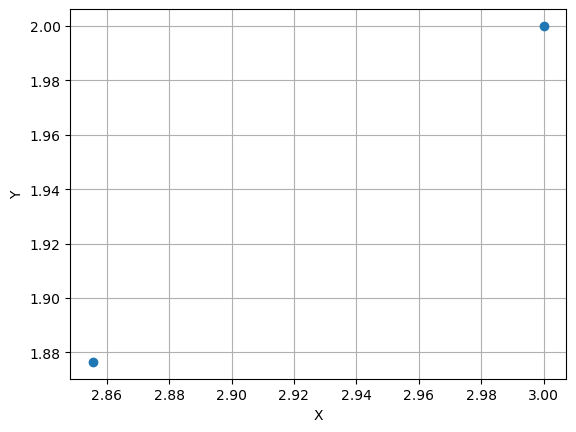

0.19004625983872814


In [13]:
for i in range(num_system):
    obs=np.array(position_t[i])
    obs=obs[:,[0,1]]
    #plt.plot(obs[:,0],obs[:,1])
    
plt.plot(np.array([3,obs[-1,0]]),np.array([2,obs[-1,1]]), 'o')
#plt.plot(obs[-1,0],obs[-1,1])
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.show()

print(reward_raw(position))

In [14]:
print(observation_t[-1])
#print(position_t[-1][0])

[2.85557599 1.87647152 0.4712389  0.         0.        ]


In [15]:
a=[1,2,4,8]
a[1:3]

[2, 4]